<a href="https://colab.research.google.com/github/NyashaEysenck/AI-Capstone-Project-with-Deep-Learning/blob/main/Zombie_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zombie Detection

## **Installing the Tensorflow 2 Object Detection API.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# uncomment the next line if you want to delete an existing models directory
!rm -rf ./models/

# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 4297, done.
remote: Counting objects: 100% (4297/4297), done.
remote: Compressing objects: 100% (3279/3279), done.
remote: Total 4297 (delta 1208), reused 2171 (delta 946), pack-reused 0 (from 0)
Receiving objects: 100% (4297/4297), 52.92 MiB | 26.22 MiB/s, done.
Resolving deltas: 100% (1208/1208), done.


In [3]:
# For compatibility. Pin tf-models-official version so it will use Tensorflow 2.15.
!sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py

In [4]:
# install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/4

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.31.0 which is incompatible.


## **Imports**

In [5]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [1]:
!pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [6]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

In [7]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """

    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size

    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """

    image_np_with_annotations = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)

    if image_name:
        plt.imsave(image_name, image_np_with_annotations)

    else:
        plt.imshow(image_np_with_annotations)

In [8]:
# uncomment the next 2 lines if you want to delete an existing zip and training directory
!rm training-zombie.zip
!rm -rf ./training

# download the images
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-3-public/datasets/training-zombie.zip \
    -O ./training-zombie.zip

# unzip to a local directory
local_zip = './training-zombie.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

rm: cannot remove 'training-zombie.zip': No such file or directory
--2024-08-22 01:59:24--  https://storage.googleapis.com/tensorflow-3-public/datasets/training-zombie.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915446 (1.8M) [application/zip]
Saving to: ‘./training-zombie.zip’

./training-zombie.z 100%[===================>]   1.83M  --.-KB/s    in 0.01s   

2024-08-22 01:59:25 (167 MB/s) - ‘./training-zombie.zip’ saved [1915446/1915446]



./training/training-zombie1.jpg
./training/training-zombie2.jpg
./training/training-zombie3.jpg
./training/training-zombie4.jpg
./training/training-zombie5.jpg


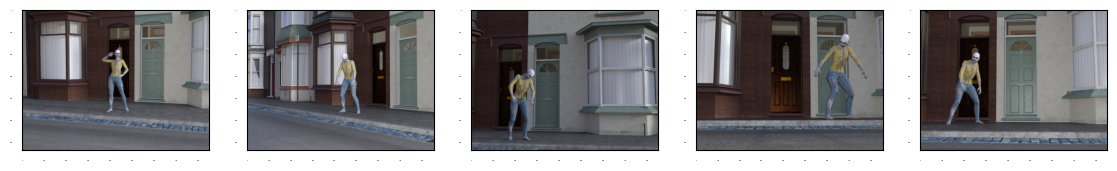

In [9]:
%matplotlib inline
train_image_dir = './training'
train_images_np = []

# run a for loop for each image
for i in range(1, 6):
  # define the path (string) for each image
  image_path = os.path.join(train_image_dir, 'training-zombie' + str(i) + '.jpg')
  print(image_path)
  # load images into numpy arrays and append to a list
  train_images_np.append(load_image_into_numpy_array(image_path))

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()


In [10]:
# Define the list of ground truth boxes
gt_boxes = []

In [11]:
# annotate the training images
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [12]:
try:
  assert(len(gt_boxes) == 5), "Warning: gt_boxes is empty. Did you click `submit`?"

except AssertionError as e:
  print(e)

# checks if there are boxes for all 5 images
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None), "There are less than 5 sets of box coordinates. " \
                                  "Please re-run the cell above to draw the boxes again.\n" \
                                  "Alternatively, you can run the next cell to load pre-determined " \
                                  "ground truth boxes."

    except AssertionError as e:
        print(e)
        break


ref_gt_boxes = [
        np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
        np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
        np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
        np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
        np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
      ]

for gt_box, ref_gt_box in zip(gt_boxes, ref_gt_boxes):
    try:
      assert(np.allclose(gt_box, ref_gt_box, atol=0.04)), "One of the boxes is too big or too small. " \
                                                          "Please re-draw and make the box tighter around the zombie."

    except AssertionError as e:
      print(e)
      break

In [13]:
# # Option 2: use given ground truth boxes
# # set this to `True` if you want to override the boxes you drew
# override = False

# # bounding boxes for each of the 5 zombies found in each image.
# # you can use these instead of drawing the boxes yourself.
# ref_gt_boxes = [
#         np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
#         np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
#         np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
#         np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
#         np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
#       ]

# # if gt_boxes is empty, use the reference
# if not gt_boxes or override is True:
#   gt_boxes = ref_gt_boxes

# # if gt_boxes does not contain 5 box coordinates, use the reference
# for gt_box in gt_boxes:
#     try:
#       assert(gt_box is not None)

#     except:
#       gt_boxes = ref_gt_boxes

#       break

In [14]:
# print the coordinates of your ground truth boxes
for gt_box in gt_boxes:
  print(gt_box)

[[0.27774305 0.4126612  0.74607639 0.59906213]]
[[0.30607639 0.45486518 0.75274305 0.61781946]]
[[0.41940972 0.18405627 0.93607639 0.34349355]]
[[0.16440972 0.62485346 0.78940972 0.91324736]]
[[0.29774305 0.12778429 0.82274305 0.35052755]]


In [17]:
# Assign the zombie class ID
zombie_class_id = 1

# define a dictionary describing the zombie class
category_index = {
    zombie_class_id: {
        'id': zombie_class_id,
        'name': 'zombie'
    }
}

# Specify the number of classes that the model will predict
num_classes = 1

In [18]:

print(category_index[zombie_class_id])

{'id': 1, 'name': 'zombie'}


In [19]:
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors = []

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):

    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))

    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))

    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)

    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')

Done prepping data.


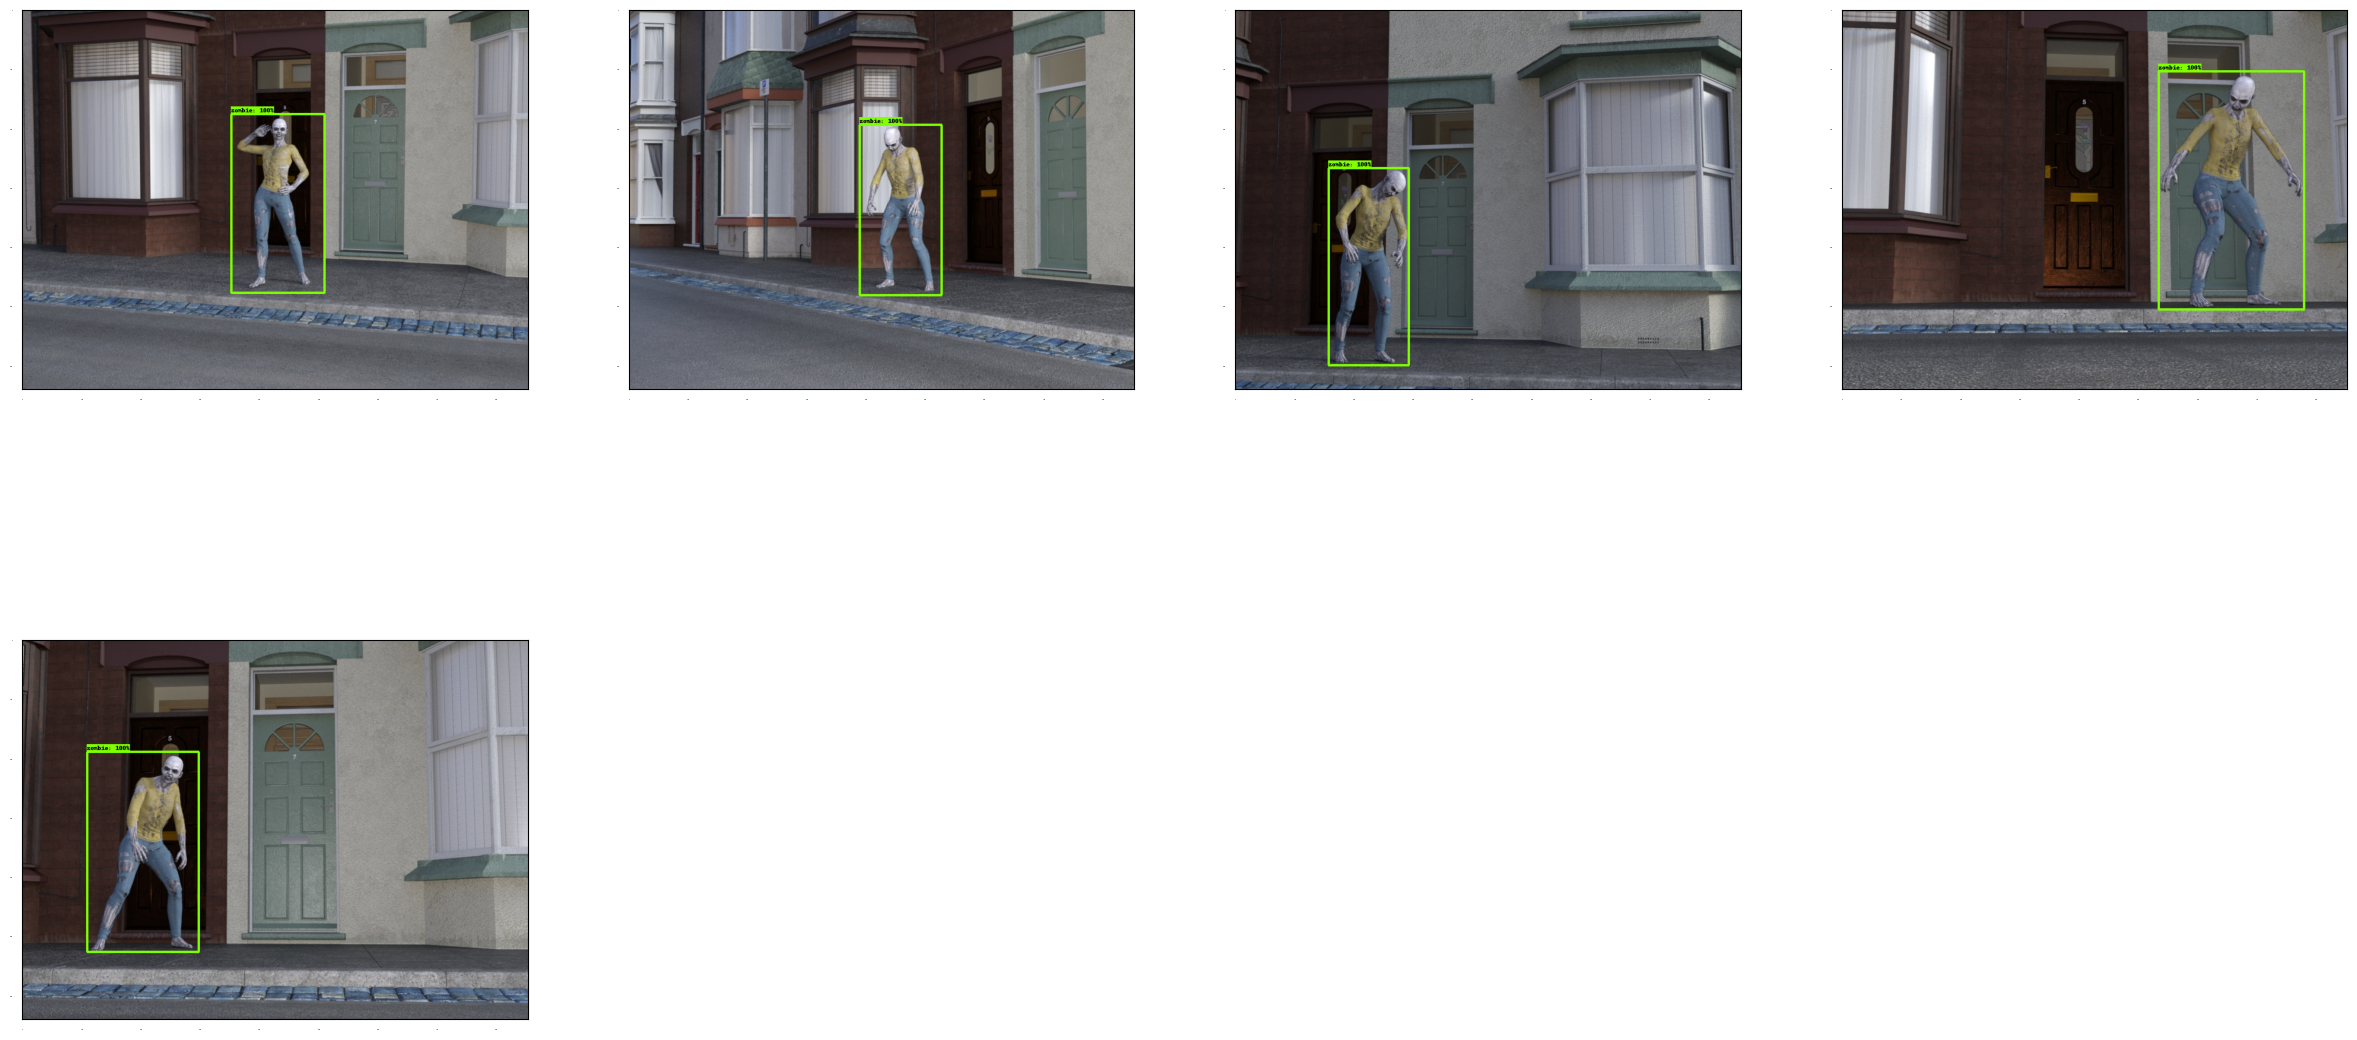

In [20]:
# give boxes a score of 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(30, 15))

# use the `plot_detections()` utility function to draw the ground truth boxes
for idx in range(5):
    plt.subplot(2, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

In [21]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# untar (decompress) the tar file
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# copy the checkpoint to the test_data folder models/research/object_detection/test_data/
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2024-08-22 02:09:11--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.101.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   299MB/s    in 0.8s    

2024-08-22 02:09:12 (299 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [22]:
tf.keras.backend.clear_session()

# define the path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = '/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

# See what configs looks like
configs

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5


In [23]:
model_config = configs.get('model')
# see what model_config looks like
model_config

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: f

In [24]:
# Modify the number of classes from its default of 90
model_config.ssd.num_classes = num_classes

# Freeze batch normalization
model_config.ssd.freeze_batchnorm = True

# See what model_config now looks like after you've customized it!
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

In [25]:
detection_model = model_builder.build(model_config=model_config, is_training=True)

print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>
